In [ ]:
# we expect TV, right?
# are you looking for a paper on TV?

In [38]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from utils import Poisson
import cuqi

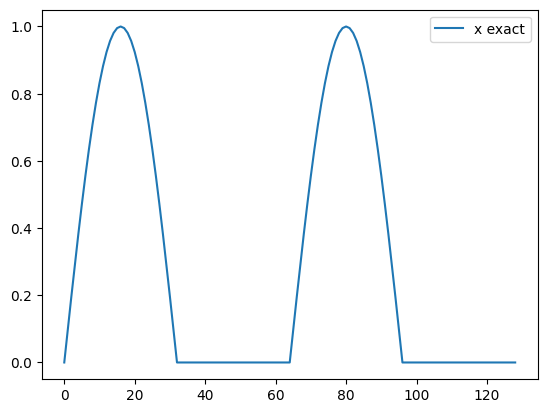

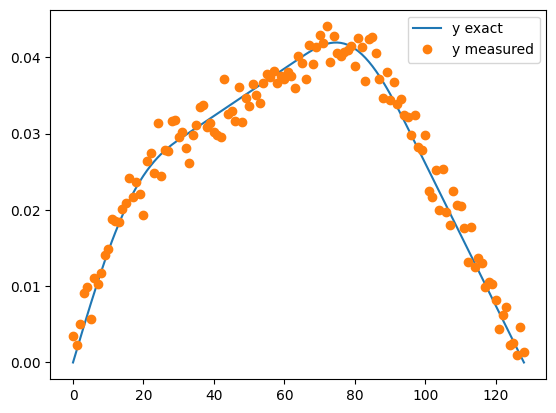

In [39]:
np.random.seed(0)

# %%
nx = 128
poisson = Poisson(nx)

signal_index = 1

if signal_index == 1:
    xx = np.linspace(0, 1, 128+1)
    x_exact = np.sin(4*np.pi*xx)
    x_exact[np.where(x_exact < 0)]=0
else:
    x_exact = np.zeros(nx+1)
    # x_exact[int(nx/3):int(nx/3*2)] = 1

    x_exact[25:35] = 0.5

    x_exact[45:60] = 1

    x_exact[80:95] = 0.8

plt.figure()
plt.plot(x_exact, label='x exact')
plt.legend()

# %%
y_exact = poisson.forward(x_exact)

noise_scale = 0.002 #0.001 #0.003 #0.003 #0.002
noise = noise_scale*np.random.randn(y_exact.size)
y_data = y_exact + noise
# %%
plt.figure()
plt.plot(y_exact, label='y exact')
plt.plot(y_data, 'o', label='y measured')
plt.legend()

In [40]:
# np.random.seed(0)

# # %%
# nx = 64
# poisson = Poisson(nx)

# # %% prepare data
# x_exact = np.zeros(nx+1)
# x_exact[int(nx/3):int(nx/3*2)] = 1
# plt.figure()
# plt.plot(x_exact, label='x exact')
# plt.legend()

# y_exact = np.ones(nx+1)
# y_exact[0] = 0
# y_exact[-1] = 0

# noise_scale = 0.1 #0.003 #0.002
# noise = noise_scale*np.random.randn(y_exact.size)
# y_data = y_exact + noise
# # %%
# plt.figure()
# plt.plot(y_exact, label='y exact')
# plt.plot(y_data, 'o', label='y measured')
# plt.legend()

Sample 1000 / 1000


Text(0.5, 1.0, 'Gaussian')

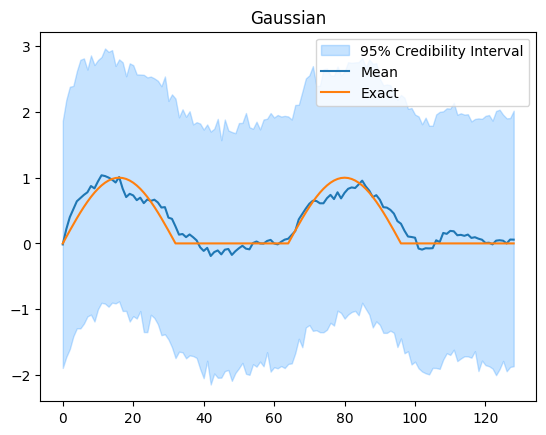

In [41]:
# %% cuqi set up
from cuqi.distribution import Gaussian, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF
from cuqi.problem import BayesianProblem
from cuqi.sampler import LinearRTO, RegularizedLinearRTO, Gibbs, Conjugate, LinearRTO

model_func = cuqi.model.LinearModel(poisson.forward, adjoint=poisson.adjoint, range_geometry=nx+1, domain_geometry=nx+1)
# %%
# linear rto
np.random.seed(0)
x  = Gaussian(0.0*np.ones(nx+1), 1)
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# BP = BayesianProblem(y, x).set_data(y=y_data)
# BP.UQ()

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_g = LinearRTO(posterior)
samples_g = sampler_g.sample(1000)

plt.figure()
samples_g.plot_ci(exact=x_exact)
plt.title('Gaussian')

In [42]:
# %%
np.random.seed(0)
# regularized linear rto
x  = RegularizedGaussian(0.0*np.ones(nx+1), 1, constraint = "nonnegativity")
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# BP = BayesianProblem(y, x).set_data(y=y_data)
# BP.UQ()

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rg = RegularizedLinearRTO(posterior)
samples_rg = sampler_rg.sample(1000)

Sample 1000 / 1000


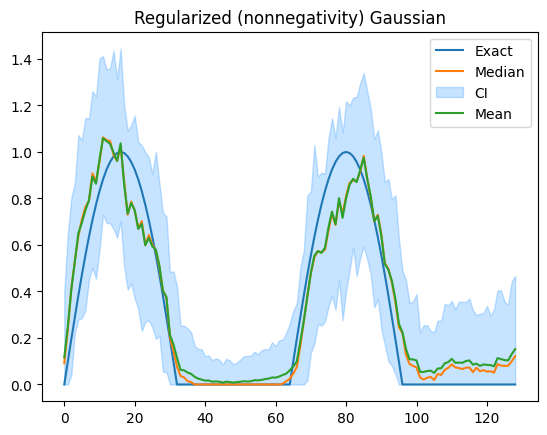

In [43]:
# %%
plt.figure()
plt.plot(x_exact)
samples_rg.plot_median()
samples_rg.plot_ci()
plt.title('Regularized (nonnegativity) Gaussian')
plt.legend(['Exact', 'Median', 'CI', 'Mean'])

In [44]:
# Regularized Gaussian with Gibbs (to learn precision as well)
np.random.seed(0)
d = Gamma(1, 1e-8)
x = RegularizedGaussian(np.zeros(nx+1), prec = lambda d:d, constraint = "nonnegativity")
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

Warmup 200 / 200
Sample 1000 / 1000


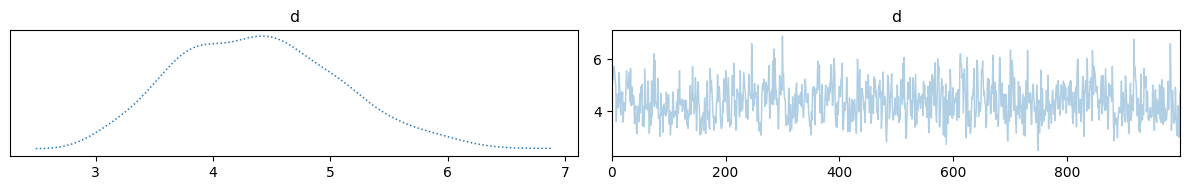

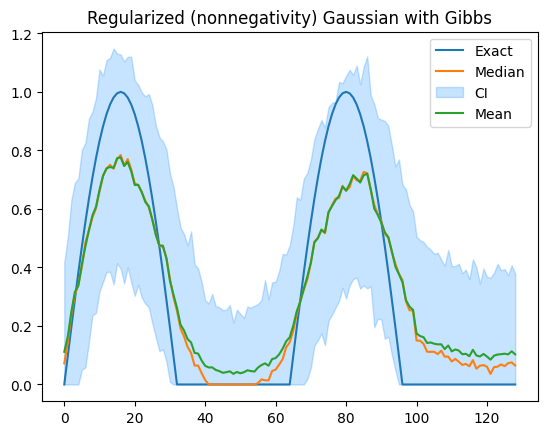

In [45]:
samples['d'].plot_trace()
# %%
plt.figure()
plt.plot(x_exact)
samples['x'].plot_median()
samples['x'].plot_ci()
plt.title('Regularized (nonnegativity) Gaussian with Gibbs')
plt.legend(['Exact', 'Median', 'CI', 'Mean'])

In [46]:
# Regularized GMRF with Gibbs (to learn precision as well)
np.random.seed(0)
d = Gamma(1, 1e-10)
x = RegularizedGMRF(np.zeros(nx+1), prec = lambda d:d, constraint="nonnegativity")
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

Warmup 200 / 200
Sample 1000 / 1000


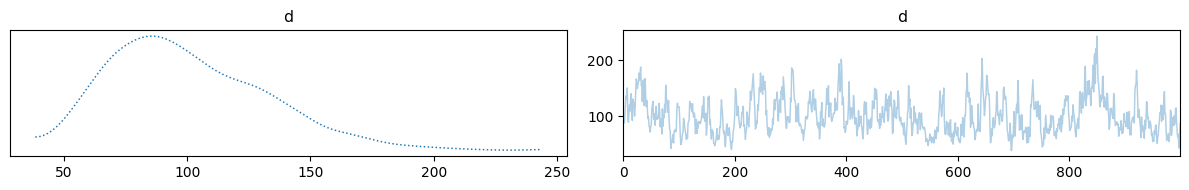

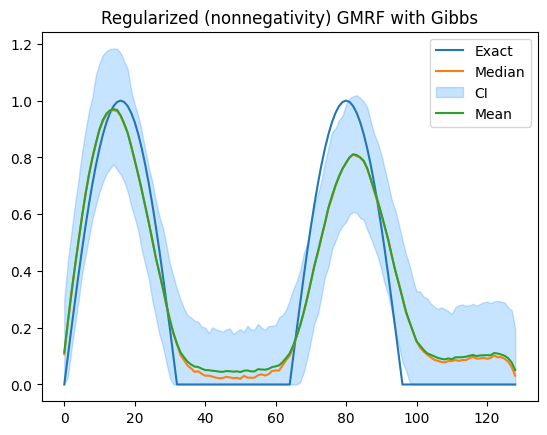

In [47]:
samples['d'].plot_trace()
# %%
plt.figure()
plt.plot(x_exact)
samples['x'].plot_median()
samples['x'].plot_ci()
plt.title('Regularized (nonnegativity) GMRF with Gibbs')
plt.legend(['Exact', 'Median', 'CI', 'Mean'])

In [48]:
# %%
np.random.seed(0)
# regularized linear rto
x  = RegularizedGMRF(0.0*np.ones(nx+1), 1, constraint = "nonnegativity")
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rg = RegularizedLinearRTO(posterior)
samples_rg = sampler_rg.sample(1000)

Sample 1000 / 1000


In [49]:
def _projectSimplex(x, radius = 1):
    ''' Condat, Laurent. "Fast projection onto the simplex and the l 1 ball." Mathematical Programming 158.1-2 (2016): 575-585.
        worst case O(n^2), average case O(nlogn)
        Technically not the faster algorithm, but the simplest
    '''
    u = np.flip(np.sort(x)) # worst case: O(n^2), average case: O(nlogn)
    K = len(x)-1
    accum = np.sum(u)
    while (accum - radius)/(K+1) >= u[K] and K > 0:
        accum -= u[K]
        K -= 1
    tau = (accum - radius)/(K+1)
    return np.maximum(x-tau, 0)

project_simplex = lambda x : _projectSimplex(x, radius = np.sum(x_exact))

In [50]:
# %%
np.random.seed(0)
# regularized linear rto
x  = RegularizedGaussian(0.0*np.ones(nx+1), 1, projector=project_simplex)
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# BP = BayesianProblem(y, x).set_data(y=y_data)
# BP.UQ()

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rg = RegularizedLinearRTO(posterior)
samples_rg = sampler_rg.sample(1000)

Sample 1000 / 1000


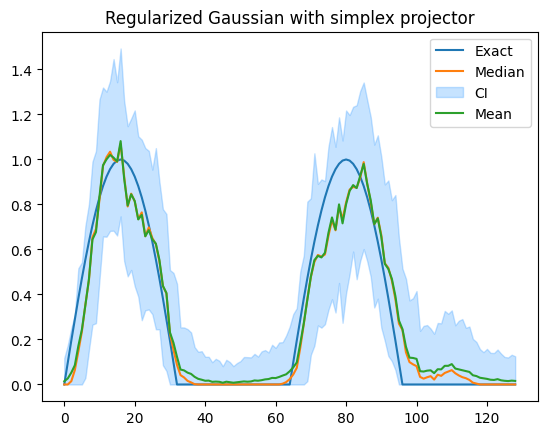

In [51]:
# %%
plt.figure()
plt.plot(x_exact)
samples_rg.plot_median()
samples_rg.plot_ci()
plt.title('Regularized Gaussian with simplex projector')
plt.legend(['Exact', 'Median', 'CI', 'Mean'])

Sample 1000 / 1000


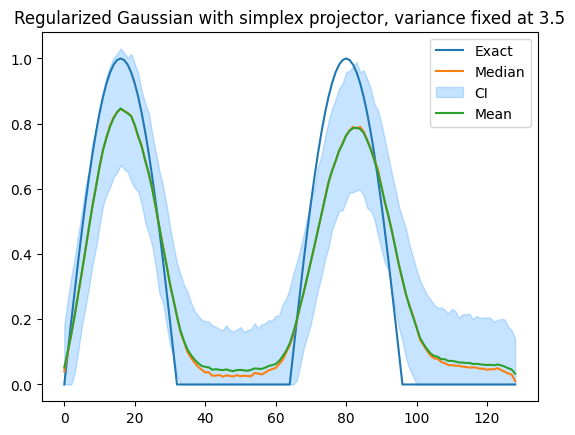

In [52]:
# %%
np.random.seed(0)
# regularized linear rto
x  = RegularizedGMRF(0.0*np.ones(nx+1), 130, projector=project_simplex)
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# BP = BayesianProblem(y, x).set_data(y=y_data)
# BP.UQ()

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rg = RegularizedLinearRTO(posterior)
samples_rg = sampler_rg.sample(1000)

# %%
plt.figure()
plt.plot(x_exact)
samples_rg.plot_median()
samples_rg.plot_ci()
plt.title('Regularized Gaussian with simplex projector, variance fixed at 3.5')
plt.legend(['Exact', 'Median', 'CI', 'Mean'])

Sample 1000 / 1000


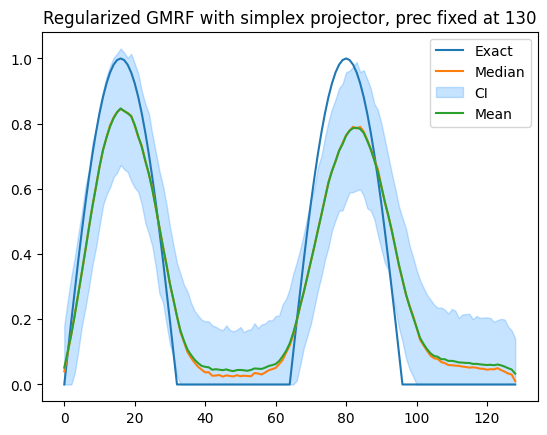

In [53]:
# %%
np.random.seed(0)
# regularized linear rto
x  = RegularizedGMRF(0.0*np.ones(nx+1), prec=130, projector=project_simplex)
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(model_func(x), measure_variance)

# BP = BayesianProblem(y, x).set_data(y=y_data)
# BP.UQ()

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rg = RegularizedLinearRTO(posterior)
samples_rg = sampler_rg.sample(1000)

# %%
plt.figure()
plt.plot(x_exact)
samples_rg.plot_median()
samples_rg.plot_ci()
plt.title('Regularized GMRF with simplex projector, prec fixed at 130')
plt.legend(['Exact', 'Median', 'CI', 'Mean'])